In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import joblib

train = pd.read_csv('../data/processed/train/train-dengue.csv')
test = pd.read_csv('../data/processed/test/test-dengue.csv')

In [7]:
# Preprocesar datos (dummy variables para categorías)
df_train = pd.get_dummies(train, columns=['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], drop_first=True)

# Separar características y etiqueta
X_train = df_train.drop('TIPO_PACIENTE', axis=1)
y_train = df_train['TIPO_PACIENTE']

# Normalizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Convertir nombres de columnas a string
X_train_df = pd.DataFrame(X_train, columns=[str(i) for i in range(X_train.shape[1])])
X_train_df['TIPO_PACIENTE'] = y_train.values

# Guardar los datos preprocesados
X_train_df.to_parquet('../data/db/processed_train_data.parquet')
joblib.dump(scaler, '../data/db/scaler.joblib')

['../data/db/scaler.joblib']

In [3]:
# Construir y evaluar el modelo
model = LogisticRegression(max_iter=1000)

# K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_results}")
print(f"Mean cross-validation accuracy: {cv_results.mean()}")

# Entrenar el modelo en todo el conjunto de entrenamiento
model.fit(X_train, y_train)

Cross-validation accuracy scores: [0.8034444  0.80182204 0.79670535 0.80841238 0.80154768]
Mean cross-validation accuracy: 0.8023863711483816


LogisticRegression(max_iter=1000)

In [8]:
# Preprocesar datos (dummy variables para categorías)
df_test = pd.get_dummies(test, columns=['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], drop_first=True)

# Separar características y etiqueta
X_test = df_test.drop('TIPO_PACIENTE', axis=1)
y_test = df_test['TIPO_PACIENTE']

# Normalizar datos
X_test = scaler.transform(X_test)

# Convertir nombres de columnas a string
X_test_df = pd.DataFrame(X_test, columns=[str(i) for i in range(X_test.shape[1])])
X_test_df['TIPO_PACIENTE'] = y_test.values

# Guardar los datos preprocesados
X_test_df.to_parquet('../data/db/processed_test_data.parquet')

In [5]:
# Modelo de regresión logística
model = LogisticRegression(max_iter=1000)

# Ajuste de hiperparámetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Ejemplo de valores para ajustar
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicción en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.803314696485623
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.96      0.89      7892
           2       0.60      0.22      0.32      2124

    accuracy                           0.80     10016
   macro avg       0.71      0.59      0.60     10016
weighted avg       0.77      0.80      0.76     10016



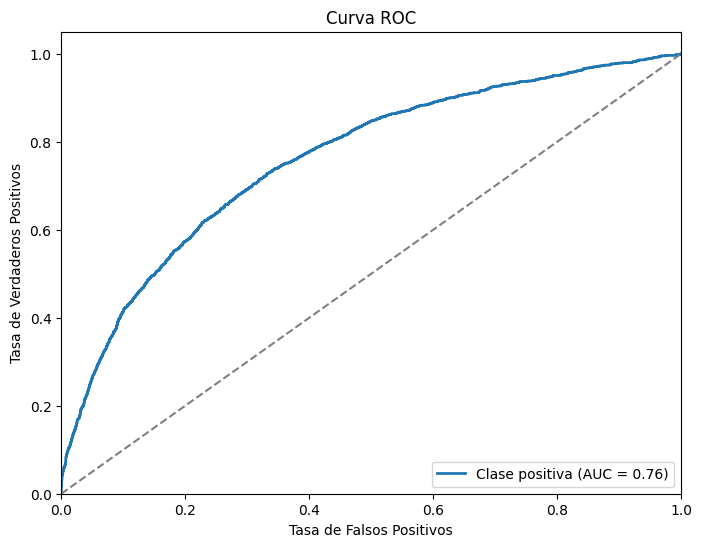

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import numpy as np


# Convertir etiquetas de y_test a 0 y 1
y_test_adjusted = np.where(y_test == 2, 1, 0)

# Calcular probabilidades de clase para el conjunto de prueba
y_prob = best_model.predict_proba(X_test)[:, 1]  # Obtener probabilidades de la clase positiva

# Calcular la curva ROC y el área bajo la curva para la clase positiva
fpr, tpr, _ = roc_curve(y_test_adjusted, y_prob)  # Calcular la curva ROC
roc_auc = auc(fpr, tpr)  # Calcular el área bajo la curva ROC

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='Clase positiva (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

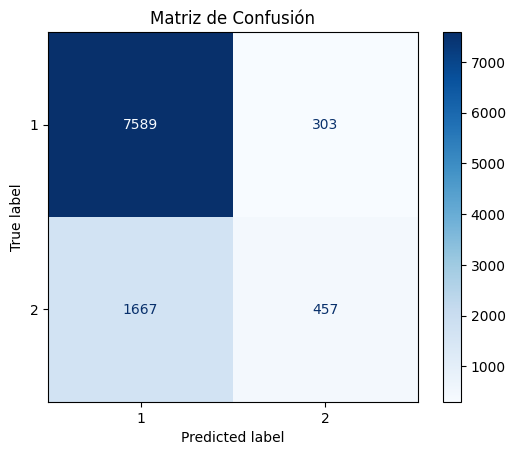

In [10]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()